In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import numpy as np
import pandas as pd
import plotly.graph_objects as go

from pathlib import Path
from tqdm.auto import tqdm
from typing import Tuple

tqdm.pandas()
pd.options.display.max_columns = None

In [4]:
# configure user
user = "jonas"  # set this to mitchel

if user.lower() == "jonas":
    BASE_PATH = "/users/jonvdrdo/jonas/data/aaa_contextaware/raw/uz_study/"
    DATA_PATH = BASE_PATH + "aligned_data"
elif user.lower() == "mitchel":
    BASE_PATH = "D:/Data/EEG_Study_1/"  # Go check 1_audio_preprocess.py
    DATA_PATH = BASE_PATH + "uz_study"

if user.lower() == "jonas":
    FEATURES_PATH = ""  # + "/features_gemaps/"
elif user.lower() == "mitchel":
    FEATURES_PATH = DATA_PATH + "/features/"

Done:
- [ ] add gender
- [ ] fix the data for the not-aligned files
- [ ] create a low-quality ptcpct list
- [ ] enlarge the EDA IBI range
- [ ] visulaize per block
- [ ] upload latest version of the data

To-do:
- [ ] extract HRV per (sub)-block

In [5]:
# LOG_FILE = Path(BASE_PATH).joinpath("Participant_key.csv")
# df_log = pd.read_csv(LOG_FILE)

# sex_mapping = {"Man": "M", "M": "M", "V": "F", "Vrouw": "F"}
# df_log["sex"] = df_log.Geslacht.apply(lambda x: sex_mapping.get(x))

# ptcpt_mask = (
#     df_log["Participant No. "].notna() & df_log["Participant No. "].str.isnumeric()
# )

# df_log_sex = df_log[ptcpt_mask][["Participant No. ", "sex"]].rename(
#     columns={"Participant No. ": "user"}
# )
# df_log_sex.to_csv("sex_mapping.csv", index=False)

In [6]:
df_log_sex = pd.read_csv('sex_mapping.csv')
df_log_sex.sample(3)

,user,sex
26,27,F
80,81,F
31,32,F


# sequential IBI

In [7]:
def parse_timeline_marker_file(df_timeline, df_marker) -> Tuple[pd.DataFrame, ...]:
    tz = "europe/brussels"
    for c in ["t_start", "t_stop"]:
        df_timeline[c] = pd.to_datetime(df_timeline[c]).dt.tz_convert(tz)
    for c in ["timestamp"]:
        df_marker[c] = pd.to_datetime(df_marker[c]).dt.tz_convert(tz)

    # 2. assert whether the start-time of the timeline file is sorted
    df_timeline = df_timeline.sort_values(by=["t_start", "Trial"])
    assert df_timeline["t_start"].is_monotonic_increasing

    # 3. Add some additional columns
    df_timeline["prev_Phase"] = df_timeline.Phase.shift(1)
    df_timeline["RESP"] = df_timeline.RESP.shift(1)  # slide response
    df_timeline["CRESP"] = df_timeline.CRESP.shift(1)  # correct slide response
    df_timeline["answered_in_time"] = df_timeline.RESP.notna()
    df_timeline["answered_correctly"] = df_timeline.RESP == df_timeline.CRESP
    df_timeline[
        "delay_slide_feedback"
    ] = df_timeline.t_start - df_timeline.t_stop.shift(1)

    return df_timeline, df_marker

In [8]:
feedback_list = []

for p in tqdm(sorted(Path(DATA_PATH).iterdir())):
    if not p.is_dir():
        continue

    # -------------- edf_aligned ----------------
    timeline_file = p.joinpath("timeline_aligned.csv")
    marker_file = p.joinpath("marker_edf_aligned.csv")
    if timeline_file.exists() and marker_file.exists():
        edf_source = "edf_aligned"

        # 1. if both files exists, read them and parse the time columns
        df_timeline = (
            pd.read_csv(timeline_file).iloc[:, 1:].drop(columns=["OnsetDelay.1"])
        )
        df_marker = pd.read_csv(marker_file).iloc[:, 1:]
        df_timeline, df_marker = parse_timeline_marker_file(df_timeline, df_marker)

        # 4. filter on the feedback events
        df_feedback = df_timeline[
            df_timeline.Phase.str.lower().str.contains("feedback")
        ].copy()

        df_feedback["user"] = p.name
        df_feedback['sex'] = df_log_sex[df_log_sex.user == int(p.name)]['sex'].values[0]
        df_feedback["edf_source_dir"] = edf_source

        # assert that all the previous phases were example slides
        assert all(df_feedback["prev_Phase"].str.lower().str.contains("slide"))
        feedback_list.append(df_feedback)

        continue

    # ------------------------ marker-aligned ---------------------------
    timeline_file = p.joinpath("timeline.csv")
    marker_file = p.joinpath("marker_edf.csv")
    if timeline_file.exists() and marker_file.exists():
        edf_source = "edf"

        # Read the files and parse the columns
        df_timeline = pd.read_csv(timeline_file).drop(columns=["OnsetDelay.1"])
        df_marker = pd.read_csv(marker_file)
        df_timeline, df_marker = parse_timeline_marker_file(df_timeline, df_marker)

        # align the timeline file to the marker file
        timeline_feedback_times = (
            df_timeline[df_timeline.Phase.str.lower().str.contains("feedback")]
            .reset_index()
            .t_start
        )
        marker_feedback_times = (
            df_marker[df_marker.action.str.lower().str.contains("feedback")]
            .reset_index()
            .timestamp
        )
        df_timeline[["t_start", "t_stop"]] += (
            marker_feedback_times - timeline_feedback_times
        ).median()

        # 4. filter on the feedback events
        df_feedback = df_timeline[
            df_timeline.Phase.str.lower().str.contains("feedback")
        ].copy()

        df_feedback["user"] = p.name
        df_feedback['sex'] = df_log_sex[df_log_sex.user == int(p.name)]['sex'].values[0]
        df_feedback["edf_source_dir"] = edf_source

        # assert that all the previous phases were example slides
        assert all(df_feedback["prev_Phase"].str.lower().str.contains("slide"))
        feedback_list.append(df_feedback)


# construct the feedback dataframe
df_feedback = pd.concat(feedback_list, axis=0, ignore_index=True)

# omit the files which have a delay larger than max_slide_delay
# NOTE: don't do this, as these are the ones who did not answer in time
# max_slide_delay = pd.Timedelta(seconds=0.1)
# print(sum(df_feedback.delay_slide_feedback > max_slide_delay))
# df_feedback = df_feedback[df_feedback.delay_slide_feedback < max_slide_delay]

# show the data
df_feedback.iloc[:, np.r_[0:4, df_feedback.shape[1] - 6: df_feedback.shape[1]]]

  0%|          | 0/85 [00:00<?, ?it/s]

,Phase,Trial,Block,t_start,answered_in_time,answered_correctly,delay_slide_feedback,user,sex,edf_source_dir
0,Controle1Feedback,1.0,4,2020-02-03 10:16:26.896047+01:00,True,False,0 days 00:00:00.075000,10,F,edf
1,Controle1Feedback,2.0,4,2020-02-03 10:17:00.344047+01:00,True,True,0 days 00:00:00.061000,10,F,edf
2,Controle1Feedback,3.0,4,2020-02-03 10:18:11.555047+01:00,True,True,0 days 00:00:00.062000,10,F,edf
3,Controle1Feedback,4.0,4,2020-02-03 10:18:32.854047+01:00,True,True,0 days 00:00:00.066000,10,F,edf
4,Controle1Feedback,5.0,4,2020-02-03 10:18:58.118047+01:00,True,True,0 days 00:00:00.068000,10,F,edf
...,...,...,...,...,...,...,...,...,...,...
4359,Stress3FeedBack,22.0,5,2020-01-31 14:00:26.135688+01:00,True,True,0 days 00:00:00.061000,9,F,edf
4360,Stress3FeedBack,23.0,5,2020-01-31 14:01:08.049688+01:00,True,False,0 days 00:00:00.067000,9,F,edf
4361,Stress3FeedBack,24.0,5,2020-01-31 14:01:22.564688+01:00,True,True,0 days 00:00:00.071000,9,F,edf
4362,Stress3FeedBack,25.0,5,2020-01-31 14:01:42.496688+01:00,True,True,0 days 00:00:00.060000,9,F,edf


In [9]:
# ------------------- HYPERPARAMS -------------------
left_slice_margin_s = 20  # the left margin from the event
right_slice_margin_s = 20  # the right maring from the event
min_r_peak_threshold = 0.6  # minimum r-peak agreement threshold to still use the data

time_threshold = 0  # first item exceeding this time_threshold will set at IBI pos 0
reference_ibi_pos = -2  # the reference position

# the IBI-pos range
min_ibi_pos_range = -7
max_ibi_pos_range = 8


# ---------------- The algorithm ------------------
# iterate over all the users in the feedback file
slcs = []
for user in tqdm(df_feedback.user.unique()):
    df_f_user = df_feedback[df_feedback.user == user]

    # fetch the correct feedback RR_interval data (matching timestamps)
    f_path = Path(DATA_PATH).joinpath(user, df_f_user.edf_source_dir.values[0])
    f_path = list(f_path.glob("rr_intervals_*.parquet"))
    if len(f_path) != 1:
        print(f"skipping user {user} f_path size {len(f_path)}")
        continue

    rr_file_user = pd.read_parquet(f_path[0]).set_index("timestamp")

    for idx, r in df_f_user.iterrows():
        t_start = r.t_start - pd.Timedelta(seconds=left_slice_margin_s)
        t_end = r.t_start + pd.Timedelta(seconds=right_slice_margin_s)
        slc = rr_file_user[t_start:t_end].copy().reset_index()

        # do not use slices with lower
        if len(slc) < 15 or any(slc["r_peak_agreement"] <= min_r_peak_threshold):
            # print(f'skipping slice user - {r.user} - {r.Phase} - {len(slc)}')
            continue

        # add a relative time col w.r.t. event and feedback_index which will be used
        # to link the data back to df_feedback
        slc["rel_event_time"] = (slc.timestamp - r.t_start).dt.total_seconds()
        slc["feedback_index"] = idx

        # determine the int-ibi pos
        slc["IBI_pos"] = slc.index - slc[slc.rel_event_time > time_threshold].index[0]
        slc["RR_delta_ms"] = (
            slc.RR_interval_ms
            - slc[slc.IBI_pos == reference_ibi_pos].RR_interval_ms.values[0]
        ).round()

        slcs.append(slc)

df_slc = pd.concat(slcs, axis=0, ignore_index=True)
del slcs

r_list = []
for feeback_idx, r in tqdm(df_feedback.iterrows()):
    rr_d = (
        df_slc[df_slc["feedback_index"] == feeback_idx]
        .copy()
        .set_index("IBI_pos")
        .sort_index()["RR_delta_ms"]
    ).loc[min_ibi_pos_range:max_ibi_pos_range]
    rr_d.index = "IBI_pos" + rr_d.index.astype("str")

    r_list.append(r.copy().append(rr_d).to_frame().T)


df_tot_merged = pd.concat(r_list, axis=0)
del r_list

  0%|          | 0/75 [00:00<?, ?it/s]

skipping user 18 f_path size 0


0it [00:00, ?it/s]

In [10]:
#df_tot_merged[df_tot_merged['IBI_pos-7'].isna()].user.value_counts()
low_quality_ecg_users = set({18, 55, 80, 13, 11, 15, 35, 77})

In [11]:
df_tot_merged.sample(3)

,Phase,Trial,Block,t_start,t_stop,Procedure[Block],Running[Block],Procedure[Trial],Running[Trial],OnsetDelay,OnsetTime,ACC,CRESP,RESP,Answer,AlgemeneList,CorrectAnswer,ActionDelay,ActionTime,OnsetToOnsetTime,RT,RTTime,DurationError,OffsetDelay,OffsetTime,FinishTime,Duration,Stress3FeedBack,Cyclus,PercentageGood,StartTrigger,FeedbackTrigger,PercentageBad,Time,TimerValue,prev_Phase,answered_in_time,answered_correctly,delay_slide_feedback,user,sex,edf_source_dir,IBI_pos-7,IBI_pos-6,IBI_pos-5,IBI_pos-4,IBI_pos-3,IBI_pos-2,IBI_pos-1,IBI_pos0,IBI_pos1,IBI_pos2,IBI_pos3,IBI_pos4,IBI_pos5,IBI_pos6,IBI_pos7,IBI_pos8
0,Stress3FeedBack,31.0,5,2020-01-30 14:00:25.205875+01:00,NaT,Stress,AlgemeneList,StressProc3,StressBlok3,73,18478722,NaN,3.0,7.0,3,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11.0,74.0,47.0,114.0,62.0,299574.0,45000.0,Stress3Slide,True,False,0 days 00:00:00.073000,7,M,edf,141.0,105.0,117.0,76.0,29.0,0.0,0.0,13.0,187.0,297.0,121.0,103.0,133.0,127.0,88.0,85.0
0,Controle3Feedback,32.0,4,2020-03-10 16:27:28.767577+01:00,NaT,Controle,AlgemeneList,ControleProc3,ControleBlok3,62,6069998,NaN,5.0,5.0,5,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10.0,71.0,61.0,128.0,54.0,NaN,45000.0,Controle3Slide,True,True,0 days 00:00:00.063000,60,F,edf_aligned,162.0,98.0,90.0,115.0,80.0,0.0,10.0,57.0,109.0,14.0,33.0,109.0,234.0,143.0,170.0,164.0
0,Controle1Feedback,5.0,4,2020-02-05 14:03:59.112211+01:00,NaT,Controle,AlgemeneList,ControleProc1,ControleBlok1,59,4446230,NaN,2.0,1.0,2,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,74.0,56.0,123.0,55.0,NaN,45000.0,Controle1Slide,True,False,0 days 00:00:00.060000,14,M,edf,102.0,49.0,64.0,73.0,37.0,0.0,55.0,75.0,51.0,10.0,8.0,60.0,3.0,-47.0,-82.0,-49.0


In [25]:
# df_tot_merged.to_parquet("df_tot_merged_ibi_pos_-2.parquet", engine="fastparquet")

## Visualizations

### Per trial & group

In [12]:
# visualizing the ibi delta
if False:
    fig_list = []
    for trial in tqdm(sorted(df_feedback.Trial.unique())):
        shown_groups = []
        fig = go.Figure()
        for group in ["Controle", "Stress"]:
            rr_group = []
            df_f_gr = df_feedback[
                (df_feedback["Procedure[Block]"] == group)
                & (df_feedback.Trial == trial)
            ]
            for feeback_idx, _ in df_f_gr.iterrows():
                rr_d = (
                    df_slc[df_slc["feedback_index"] == feeback_idx]
                    .copy()
                    .set_index("IBI_pos")
                    .sort_index()["RR_delta_ms"]
                )
                rr_group.append(rr_d)

            df_rr_group = pd.concat(rr_group, axis=1, ignore_index=False)
            rr_group_mean = df_rr_group.mean(axis=1)
            rr_group_std = df_rr_group.std(axis=1)
            fig.add_trace(
                go.Scattergl(
                    x=rr_group_mean.index,
                    y=rr_group_mean,
                    error_y=dict(type="data", array=rr_group_std, visible=True),
                    mode="markers+lines",
                    name=group + f" n= {df_rr_group.shape[1]}",
                    legendgroup=group,
                    showlegend=group not in shown_groups,
                )
            )
            shown_groups.append(group)

        fig.update_layout(height=400, title=f"feedback - trial {trial}", title_x=0.5)
        fig.update_xaxes(title_text="Sequential IBI")
        fig.update_yaxes(title_text=f"Delta IBI (ref IBI_{reference_ibi_pos}) (ms)")
        fig.show()
        fig_list.append(fig)

# from context_aware.visualizations.plotly import figs_to_html
# figs_to_html(fig_list, 'trial_sequential_ibi.html')

### Per group & answered-in time

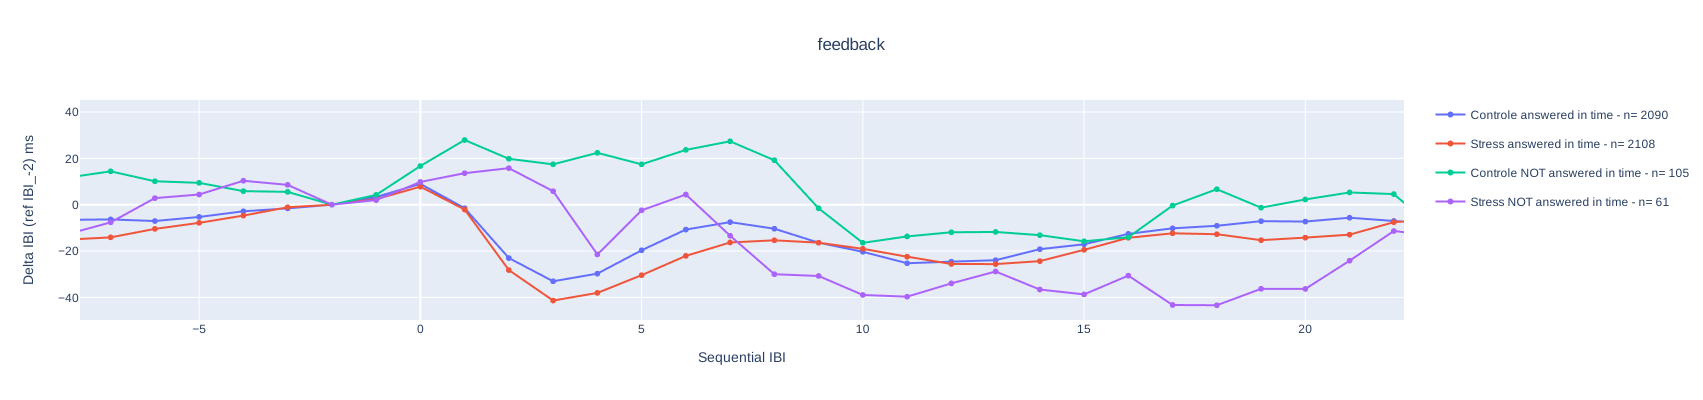

In [31]:
fig_list = []
fig = go.Figure()
for answer_in_time in [True, False]:
    shown_groups = []
    for group in ["Controle", "Stress"]:
        rr_group = []
        df_f_gr = df_feedback[
            (df_feedback["Procedure[Block]"] == group)
            & (df_feedback.answered_in_time == answer_in_time)
        ]
        for feeback_idx, _ in df_f_gr.iterrows():
            rr_d = (
                df_slc[df_slc["feedback_index"] == feeback_idx]
                .copy()
                .set_index("IBI_pos")
                .sort_index()["RR_delta_ms"]
            )
            rr_group.append(rr_d)

        df_rr_group = pd.concat(rr_group, axis=1, ignore_index=False)
        rr_group_mean = df_rr_group.mean(axis=1)
        rr_group_std = df_rr_group.std(axis=1)
        fig.add_trace(
            go.Scattergl(
                x=rr_group_mean.index,
                y=rr_group_mean,
                # error_y=dict(type="data", array=rr_group_std, visible=True),
                mode="markers+lines",
                name=group
                + f"{' NOT' if not answer_in_time else ''} answered in time - n= {df_rr_group.shape[1]}",
                legendgroup=group + str(answer_in_time),
                showlegend=group not in shown_groups,
            )
        )
        shown_groups.append(group)

fig.update_layout(height=400, title="feedback", title_x=0.5)
fig.update_xaxes(title_text="Sequential IBI")
fig.update_yaxes(title_text=f"Delta IBI (ref IBI_{reference_ibi_pos}) ms")

### Per group & answered correctly

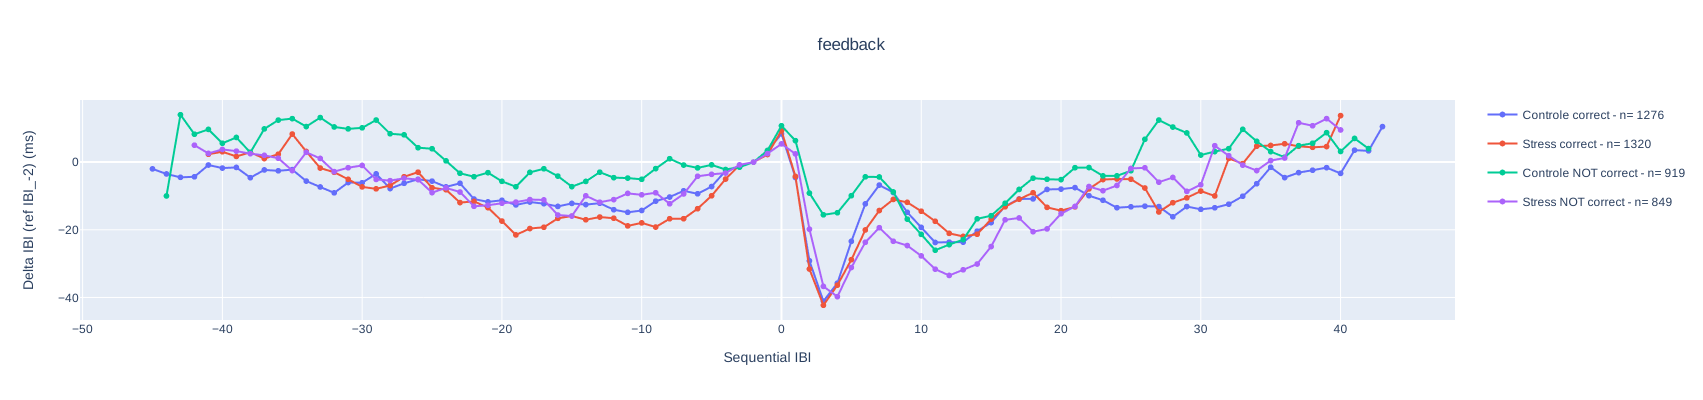

In [32]:
fig_list = []
fig = go.Figure()
for answered_correctly in [True, False]:
    shown_groups = []
    for group in ["Controle", "Stress"]:
        rr_group = []
        df_f_gr = df_feedback[
            (df_feedback["Procedure[Block]"] == group)
            & (df_feedback.answered_correctly == answered_correctly)
        ]
        for feeback_idx, _ in df_f_gr.iterrows():
            rr_d = (
                df_slc[df_slc["feedback_index"] == feeback_idx]
                .copy()
                .set_index("IBI_pos")
                .sort_index()["RR_delta_ms"]
            )
            rr_group.append(rr_d)

        df_rr_group = pd.concat(rr_group, axis=1, ignore_index=False)
        rr_group_mean = df_rr_group.mean(axis=1)
        rr_group_std = df_rr_group.std(axis=1)
        fig.add_trace(
            go.Scattergl(
                x=rr_group_mean.index,
                y=rr_group_mean,
#                 error_y=dict(type="data", array=rr_group_std, visible=True),
                mode="markers+lines",
                name=group
                + f"{' NOT' if not answered_correctly else ''} correct - n= {df_rr_group.shape[1]}",
                legendgroup=group + str(answered_correctly),
                showlegend=group not in shown_groups,
            )
        )
        shown_groups.append(group)

fig.update_layout(height=400, title="feedback", title_x=0.5)
fig.update_xaxes(title_text="Sequential IBI")
fig.update_yaxes(title_text=f"Delta IBI (ref IBI_{reference_ibi_pos}) (ms)")
fig.show()

In [13]:
fig = go.Figure()
for sex, group, answered_in_time in [
    ("M", "Controle", True),
    ("M", "Stress", True),
    ("F", "Controle", True),
    ("F", "Stress", True),
]:
    rr_group = []
    df_f_gr = df_feedback[
        (df_feedback["Procedure[Block]"] == group)
        & (df_feedback.sex == sex)
        & (df_feedback.answered_in_time == answered_in_time)
    ]
    for feeback_idx, _ in df_f_gr.iterrows():
        rr_d = (
            df_slc[df_slc["feedback_index"] == feeback_idx]
            .copy()
            .set_index("IBI_pos")
            .sort_index()["RR_delta_ms"]
        )
        rr_group.append(rr_d)

    df_rr_group = pd.concat(rr_group, axis=1, ignore_index=False)
    rr_group_mean = df_rr_group.mean(axis=1)
    rr_group_std = df_rr_group.std(axis=1)
    fig.add_trace(
        go.Scattergl(
            x=rr_group_mean.index,
            y=rr_group_mean,
            #                 error_y=dict(type="data", array=rr_group_std, visible=True),
            mode="markers+lines",
            name=sex
            + " - "
            + group
            + "- answered "
            + ("" if answered_in_time else "not")
            + " in time",
            legendgroup=sex,
            showlegend=True,
        )
    )
    shown_groups.append(group)

fig.update_layout(height=400, title="feedback", title_x=0.5)
fig.update_xaxes(title_text="Sequential IBI")
fig.update_yaxes(title_text=f"Delta IBI (ref IBI_{reference_ibi_pos}) (ms)")
fig.show()

NameError: name 'shown_groups' is not defined

In [ ]:
# [
#     ("M", "Controle", True, 1),
#     ("M", "Controle", True, 2),
#     ("M", "Controle", True, 3),
#     ("M", "Stress", True, 1),
#     ("M", "Stress", True, 2),
#     ("M", "Stress", True, 3),
#     ("F", "Controle", True, 1),
#     ("F", "Controle", True, 2),
#     ("F", "Controle", True, 3),
#     ("F", "Stress", True, 1),
#     ("F", "Stress", True, 2),
#     ("F", "Stress", True, 3),
# ]

In [36]:
import plotly.express as px

## Block & stress

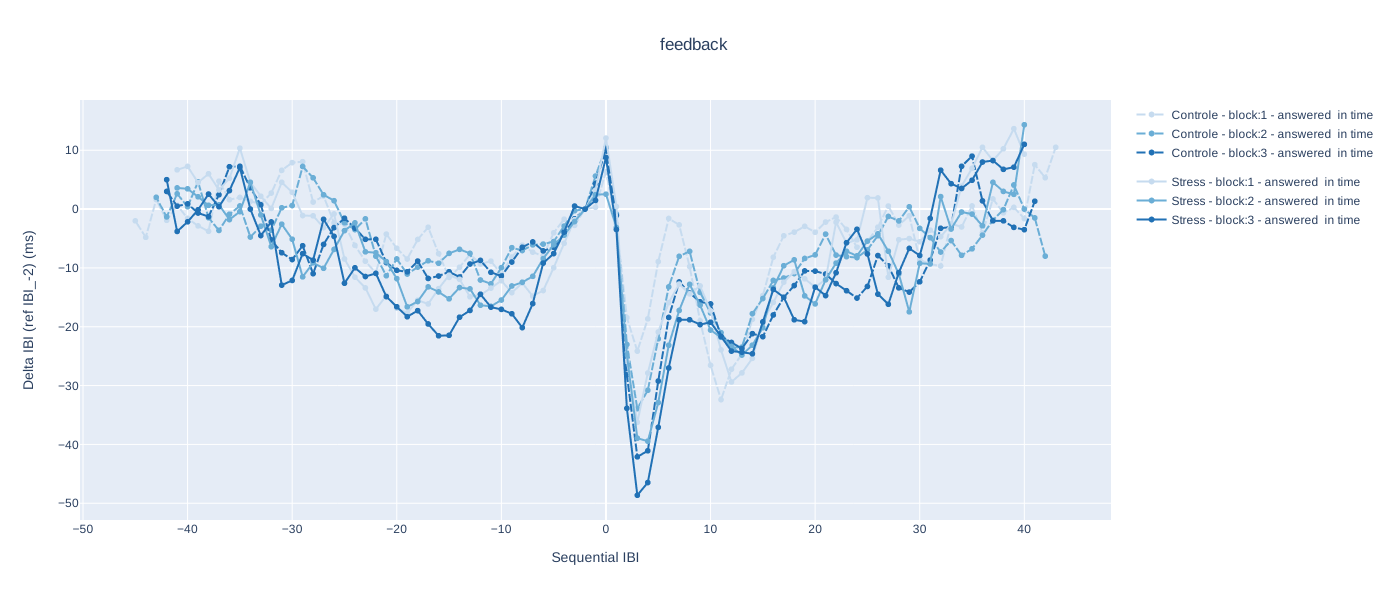

In [52]:
pallette_dict = {
    'Controle': px.colors.sequential.Blues[2:],
    'Stress': px.colors.sequential.Blues[2:],
}

fig = go.Figure()
for group, answered_in_time, level  in [
    ("Controle", True, 1),
    ("Controle", True, 2),
    ("Controle", True, 3),
    ("Stress", True, 1),
    ("Stress", True, 2),
    ("Stress", True, 3),
]:
    rr_group = []
    df_f_gr = df_feedback[
        (df_feedback["Procedure[Block]"] == group)
        & df_feedback.Phase.str.contains(str(level))
        & (df_feedback.answered_in_time == answered_in_time)
    ]
    for feeback_idx, _ in df_f_gr.iterrows():
        rr_d = (
            df_slc[df_slc["feedback_index"] == feeback_idx]
            .copy()
            .set_index("IBI_pos")
            .sort_index()["RR_delta_ms"]
        )
        rr_group.append(rr_d)

    df_rr_group = pd.concat(rr_group, axis=1, ignore_index=False)
    rr_group_mean = df_rr_group.mean(axis=1)
    rr_group_std = df_rr_group.std(axis=1)
    fig.add_trace(
        go.Scattergl(
            x=rr_group_mean.index,
            y=rr_group_mean,
            line_color=pallette_dict[group][(level-1)*2],
            # error_y=dict(type="data", array=rr_group_std, visible=True),
            mode="markers+lines",
            line_dash=('dash' if group == 'Controle' else None),
            name=group + " - block:" + str(level)
            + " - answered "
            + ("" if answered_in_time else "not")
            + " in time",
            legendgroup=group,
            showlegend=True,
        )
    )

fig.update_layout(height=600, title="feedback", title_x=0.5)
fig.update_xaxes(title_text="Sequential IBI")
fig.update_yaxes(title_text=f"Delta IBI (ref IBI_{reference_ibi_pos}) (ms)")
fig.show()